In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets
from torchvision import transforms
import torchvision
import os
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as tutils
import imageio
import pickle

In [2]:
# Options being used 
batch_size = 128
imgDim = 64
path = './genImg/'
dataSetPath = './Data/CelebA'
showPlot = False
savePlot = True
num_epochs = 200
IS_CUDA = False

In [3]:
transform = transforms.Compose([
        transforms.Resize(imgDim),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

dataset = datasets.ImageFolder(dataSetPath, transform)
data_loader = torch.utils.data.DataLoader(dataset,batch_size=batch_size, shuffle=True)

In [7]:
# Helper routines
if torch.cuda.is_available():
    IS_CUDA = True
    
def var(x):
    if IS_CUDA:
        x = x.cuda()
    return Variable(x)

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def generate_animation(root, epoch, name):
    images = []
    for e in range(epoch):
        img_name = root+'/image_'+str(e)+'.png'
        images.append(imageio.imread(img_name))
    imageio.mimsave(root+ '/' + name +'.gif', images, fps=5)

def drawLossPlot(generatorLoss, discriminatorLoss, showPlot = False, savePlot = True, loc = ""):
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Vanilla GAN Loss')
    plt.plot(generatorLoss, label='Generator Loss')
    plt.plot(discriminatorLoss, label='Discriminator Loss')
    legend = plt.legend(loc='upper right', shadow=True)
    
    if showPlot:
        plt.show()
    if savePlot:
        plt.savefig(loc+'Loss_Plot_Vanilla_GAN_'+str(num_epochs)+'.png')

def save_image(pic, path):
    grid = torchvision.utils.make_grid(pic, nrow=8, padding=2)
    ndarr = grid.mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()
    im = Image.fromarray(ndarr)
    im.save(path)

class LossModule: 
    def __init__(self):
        self.D_loss = []
        self.G_loss = []

    def insertDiscriminatorLoss(self, lossVal):
        self.D_loss.append(lossVal)
    
    def insertGeneratorLoss(self, lossVal):
        self.G_loss.append(lossVal)
    
    def getDiscriminatorLoss(self):
        return self.D_loss
    
    def getGeneratorLoss(self):
        return self.G_loss
    

In [8]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

# G(z)
class generator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(100, d*8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*8)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 3, 4, 2, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        # x = F.relu(self.deconv1(input))
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = F.tanh(self.deconv5(x))

        return x

class discriminator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, 1, 4, 1, 0)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = F.sigmoid(self.conv5(x))

        return x
    
G = generator(128)
D = discriminator(128)
G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)

if IS_CUDA:
    D.cuda()
    G.cuda()

In [9]:
print G

generator(
  (deconv1): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
  (deconv1_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True)
  (deconv2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
  (deconv3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (deconv4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv4_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (deconv5): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)


In [10]:
lossCriterion = nn.BCELoss()
G_opt = torch.optim.Adam(G.parameters(), lr = 0.0002)
D_opt = torch.optim.Adam(D.parameters(), lr = 0.0002)
lossManager = LossModule()
lossCriterion = nn.BCELoss()
fixed_x = var(torch.randn((5 * 5, 100)).view(-1, 100, 1, 1))    # fixed noise
#fixed_noise = var(torch.randn(batch_size, 64))

In [11]:
outputImages = []
def train(num_epochs = 10, d_iter = 1):
    for epoch in range(num_epochs):
        for data in data_loader:
            image, _  = data
            bSize = image.size()[0]
            #image = var(image.view(image.size(0),  -1))
            # Train Discriminator
            # print image.size()
            #for k in range(0, d_iter):
            # For Log D(x)
            image = var(image)
            D_real = D(image)
            # For Log(1 - D(G(Z)))
            Z_noise = var(torch.randn(bSize, 100)).view(-1, 100, 1, 1)
            G_fake = G(Z_noise)
            D_fake = D(G_fake)

            # Calculate Discriminator Loss
            D_real_loss = lossCriterion(D_real, var(torch.ones(bSize, 1)))
            D_fake_loss = lossCriterion(D_fake, var(torch.zeros(bSize, 1)))
            D_loss = D_real_loss + D_fake_loss

            # Backprop Discriminator
            D.zero_grad()
            D_loss.backward()
            D_opt.step()

                
            # Train Generator
            Z_noise = var(torch.randn(bSize, 100)).view(-1, 100, 1, 1)
            G_fake = G(Z_noise)
            D_fake = D(G_fake)
            # Compute Generator Loss
            G_loss = lossCriterion(D_fake, var(torch.ones(bSize, 1)))
            
            # Backprop Genearator
            D.zero_grad()
            G.zero_grad()
            G_loss.backward()
            G_opt.step()
            
        #print epoch
        print 'Epoch [{}/{}], Discriminator {:.4f}, Generator {:.4f}'.format(epoch+1, num_epochs, D_loss.data[0], G_loss.data[0])
        lossManager.insertDiscriminatorLoss(D_loss.data[0])
        lossManager.insertGeneratorLoss(G_loss.data[0])
        pic = Generator(fixed_x)
        pic = pic.view(pic.size(0), 1, 28, 28) 
        pic = denorm(pic.data)
        outputImages.append(pic)
        #torchvision.utils.save_image(pic, path+'image_{}.png'.format(epoch))
        save_image(pic, path+'image_{}.png'.format(epoch))             

In [12]:
train(num_epochs)

In [ ]:
# Plot the Loss for Generator and Discriminator
drawLossPlot(lossManager.getGeneratorLoss(), lossManager.getDiscriminatorLoss(), showPlot = True, savePlot = True)

In [13]:
# Generate GIF
num_epochs = 80
generate_animation(path, num_epochs, 'Vanilla_Gan')

In [65]:
# Save the model
torch.save(Generator.state_dict(), './Generator.pkl')
torch.save(Discriminator.state_dict(), './Discriminator.pkl')
pickle.dump(lossManager, open( "LossManager.pkl", "wb" ))

In [11]:
# Load Loss Manager for viewing data of 200 iterations
lossManagerTrained = pickle.load(open( "./LossManager.pkl", "rb" ))

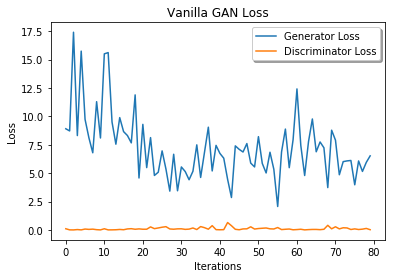

In [15]:
drawLossPlot(lossManagerTrained.getGeneratorLoss(), lossManagerTrained.getDiscriminatorLoss())

In [87]:
#drawLossPlot(lossManagerTrained.getGeneratorLoss(), lossManagerTrained.getDiscriminatorLoss(), showPlot = False, savePlot = True, loc = "200Iteration")
#drawLossPlot(lossManagerTrained.getGeneratorLoss(), lossManagerTrained.getDiscriminatorLoss(), showPlot = True, savePlot = False, loc = "200Iteration")

In [2]:
# Load model for debugging and testing
#Generator.load_state_dict(torch.load('Generator200.pkl'))
#Discriminator.load_state_dict(torch.load('Discriminator200.pkl'))